## Settings

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [341]:
import os
import sys

import numpy as np
import pandas as pd
from plotnine import * ## ggplot for python

from sklearn.metrics import mean_squared_error

In [3]:
if not 'covid' in os.listdir():
    sys.path.append('..')
    
import covid

## Loading

In [4]:
from covid.dataset import fetch_daily_case

In [5]:
data = fetch_daily_case(update=True, return_data=True)

In [239]:
data = (
    data
    .query('source_nom == "Ministère des Solidarités et de la Santé"')
    .query('granularite == "pays"')
)

## Visualize

In [242]:
data['date'] = pd.to_datetime(data['date'])
data['week'] = data['date'].dt.week

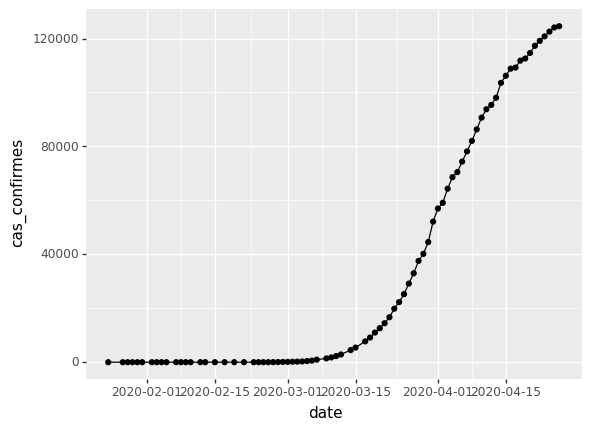

<ggplot: (-9223371856808020368)>

In [243]:
(
    ggplot(data)
    + aes(x='date', y='cas_confirmes')
    + geom_line()
    + geom_point()
)

C:\Users\leo.grosjean\AppData\Local\Continuum\anaconda3\envs\covid\lib\site-packages\plotnine\layer.py:452: PlotnineWarning:

geom_point : Removed 33 rows containing missing values.



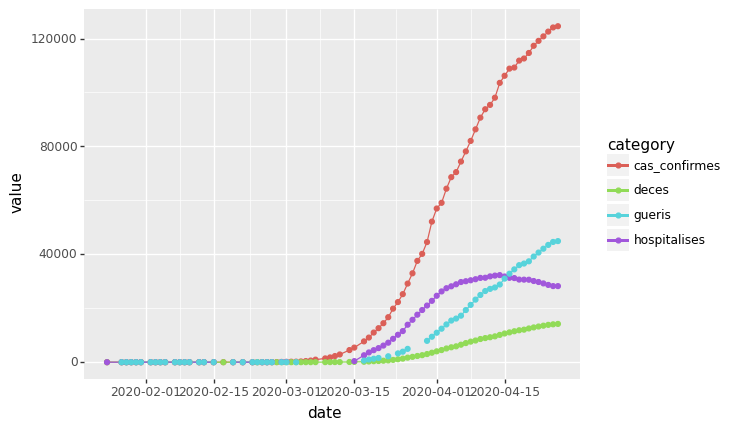

<ggplot: (-9223371856808123164)>

In [244]:
data_ = (
    data
    .filter(['date', 'cas_confirmes', 'deces', 'hospitalises', 'gueris'])
    .melt(id_vars=['date'], var_name='category', value_name='value')
)

(
    ggplot(data_)
    + aes(x='date', y='value', color='category')
    + geom_line()
    + geom_point()
)

## Inference

### Define constants

In [335]:
from covid.models import SIR, SEIDR
from hyperopt import fmin, hp, tpe

In [418]:
N = 6.5e7
I0 = 2
init_state = (N-I0, I0, 0)

start_date = data['date'].min()
end_date = data['date'].max()

dates = data['date']

data['gueris'] = data['gueris'].interpolate().fillna(0)
data['cas_confirmes'] = data['cas_confirmes'].interpolate().fillna(0)
data['hospitalises'] = data['hospitalises'].interpolate().fillna(0)
data['deces'] = data['deces'].interpolate().fillna(0)

### SIR

In [319]:
gamma_0 = 1/4
R0 = 5
beta_0 = gamma_0 * R0 
start = (beta_0, gamma_0)

In [328]:
def fun_sir(x):
    beta, gamma = x

    model = SIR(N, beta, gamma)
    res = model.solve(init_state, start_date=start_date)
    
    r_pred = res.loc[dates, 'R']
    i_pred = res.loc[dates, 'I']
    
    return np.sqrt(
#         mean_squared_error(r_pred, data['gueris']) + \
        mean_squared_error(i_pred, data['cas_confirmes'])
    )

In [338]:
spaces_sir = (
    hp.normal('beta', 0.5, 0.3),
    hp.uniform('gamma', 0.5, 3)
)

In [330]:
best = fmin(
    fn=fun_sir,
    space=spaces_sir,
    algo=tpe.suggest,
    max_evals=1000)

100%|████████████████████████████████████████████| 1000/1000 [02:25<00:00,  6.89trial/s, best loss: 28949.841952529023]


In [331]:
print(best)

{'beta': 0.9191158044430806, 'gamma': 0.7938946784419347}


In [332]:
model = SIR(N, best["beta"], best["gamma"])
res = model.solve(init_state, start_date = start_date)

In [333]:
data_merge = (
    data
    .filter(['date', 'cas_confirmes', 'deces', 'gueris', 'hospitalises'])
    .merge(
        res.reset_index(), 
        left_on='date', 
        right_on='index',
        how='left'
    )
    .melt(
        id_vars='date', 
        value_vars=['gueris', 'cas_confirmes', 'R', 'I'], 
        var_name='var', 
        value_name='value'
    )
)

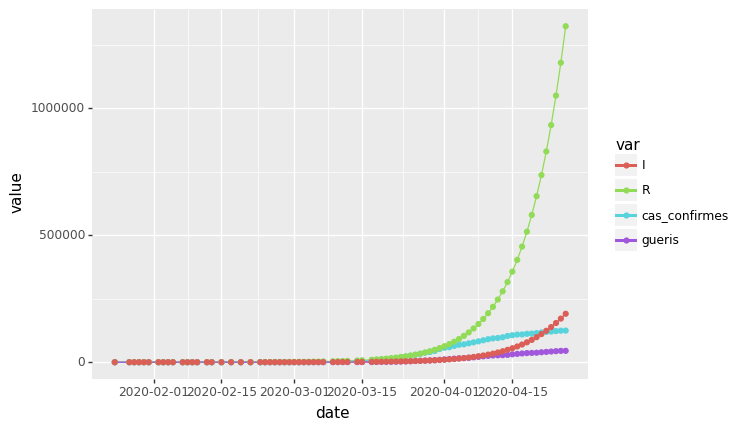

<ggplot: (-9223371856813264000)>

In [334]:
g = (
    ggplot(data_merge)
    + aes(x='date', y='value', color='var')
    + geom_line()
    + geom_point()
)

### SEIDIR

In [437]:
delta = 1/3 # Incubation time = 3 days
alpha = 0.2 # probability to die
rho = 1/9 # 9 ndays before death 

In [438]:
def fun_seidr(x):
    beta, R0, I0 = x
    
    gamma = beta * R0
    
    init_state_seidr = (N - I0, I0, 0, 0, 0)

    model = SEIDR(N, beta=beta, delta=delta, gamma=gamma, rho=rho, alpha=alpha)
    res = model.solve(init_state_seidr, start_date=start_date)
    
    r_pred = res.loc[dates, 'R']
    i_pred = res.loc[dates, 'I']
    d_pred = res.loc[dates, 'D']
    
    return np.sqrt(
        mean_squared_error(r_pred, data['gueris']) + \
        mean_squared_error(d_pred, data['deces'])  + \
        mean_squared_error(i_pred, data['cas_confirmes'])
    )

In [439]:
spaces_seidr = (
    hp.normal('beta', 0.5, 0.3),
    hp.normal('R0', 3.31, 0.3),
    hp.normal('I0', 15.8, 6)
)

In [440]:
best_seidr = fmin(
    fn=fun_seidr,
    space=spaces_seidr,
    algo=tpe.suggest,
    max_evals=1000)

print(best_seidr)

  3%|█▎                                           | 28/1000 [00:30<1:02:55,  3.88s/trial, best loss: 60262.82318240116]

C:\Users\leo.grosjean\AppData\Local\Continuum\anaconda3\envs\covid\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning:

Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.




100%|████████████████████████████████████████████| 1000/1000 [06:11<00:00,  2.69trial/s, best loss: 22971.612561659127]
{'I0': 112.55905082290802, 'R0': 0.21505836016013677, 'beta': 0.17091512206793538}


In [442]:
seidr = SEIDR(N, beta=best_seidr['beta'], delta=delta, gamma=best_seidr['beta']*best_seidr['R0'], rho=rho, alpha=alpha)

In [448]:
init_state_seidr = (N - best_seidr['I0'], best_seidr['I0'], 0, 0, 0)

data_pred = (
    seidr.solve(init_state_seidr, start_date = start_date)
    .filter(['I', 'D', 'R', 'type'])
    .assign(type='pred')
    .reset_index()
)

In [449]:
data_true = (
    data
    .filter(['date', 'cas_confirmes', 'deces', 'gueris'])
    .rename(columns={'date': 'index', 'cas_confirmes': 'I', 'deces': 'D', 'gueris': 'R'})
    .assign(type='true')
)

In [450]:
data_all = (
    pd.concat([data_pred, data_true])
    .melt(
        id_vars=['index', 'type'], 
        value_vars=['I', 'D', 'R'], 
        var_name='var', 
        value_name='value'
    )
    .query("index < @end_date")
)

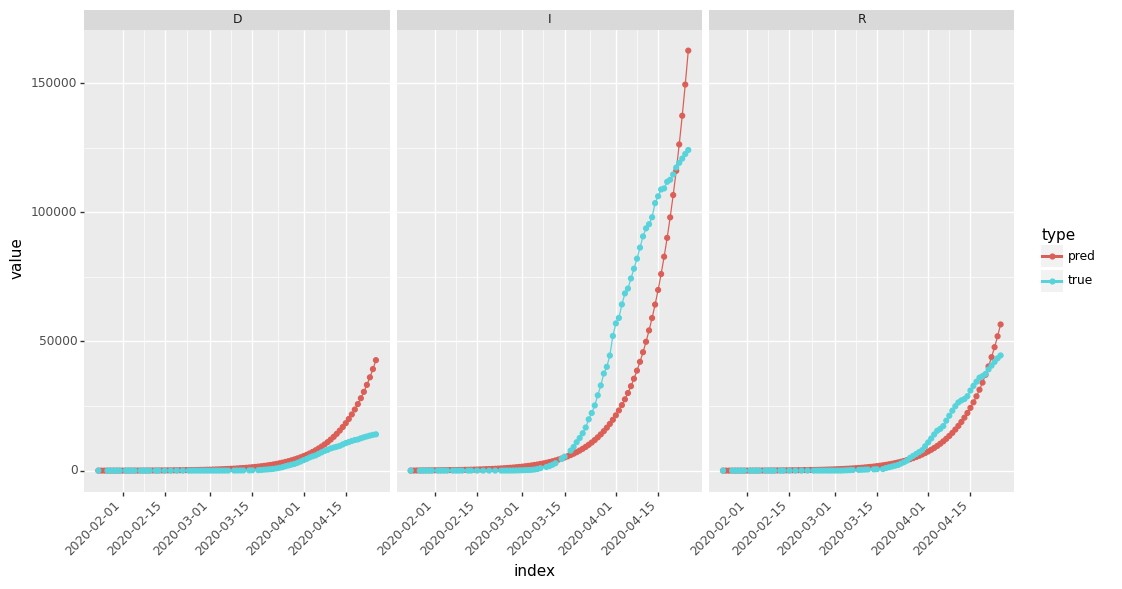

<ggplot: (-9223371856805228884)>

In [453]:
(
    ggplot(data_all)
    + aes(x='index', y='value', color='type')
    + geom_line()
    + geom_point()
    + facet_wrap('var')
    + theme(
        figure_size=(12, 6), 
        axis_text_x=element_text(rotation=45, hjust=1)
    )
)

### SEIHDR 

In [476]:
from covid.models import SEIHDR
from covid.policies.utils import multiple_sigmoid_response
from datetime import date

In [484]:
lockdown_start_date = date(2020, 3, 17)
lockdown_end_date = date(2020, 5, 11)

start_date_dt = date(start_date.year, start_date.month, start_date.day)

lockdown_after = (lockdown_start_date - start_date_dt).days

lockdown_implementation_days = 6

exit = (lockdown_end_date - start_date_dt).days

In [482]:
spaces_seihdr = (
#     hp.normal('beta', 0.5, 0.3),
    hp.normal('R0', 3.31, 0.3),
    hp.normal('R1', 0.5, 0.3),
    hp.normal('I0', 15.8, 6),
)

In [481]:
gamma = 1/4 # rate of infection
delta = 1/3 # incubation time
theta = 1/5 # ndays before complication
kappa = 1/10 # ndays before symptoms disappear
phi = 0.5 # probability of complications
alpha = 0.2 # probability to die
rho = 1/9 # 9 ndays before death

In [521]:
def error(y_pred, y_true):
    return mean_squared_error(y_pred, y_true)/(np.max(y_true)**2)

In [522]:
def fun_seihdr(x):
    R0, R1, I0 = x
    
    beta_high = gamma * R0
    beta_low = gamma * R1
    betas = [beta_low,beta_high]
    
    def beta_lockdown(y,t,exit):
        return multiple_sigmoid_response(t,beta_high,betas,[lockdown_after,exit],lockdown_implementation_days)
    
    init_state_seihdr = (N - I0, I0, 0, 0, 0, 0)

    model = SEIHDR(
        N, 
        beta=lambda y,t : beta_lockdown(y,t,exit), 
        delta=delta, 
        gamma=gamma, 
        rho=rho, 
        alpha=alpha,
        theta=theta,
        phi=phi,
        kappa=kappa
    )
    res = model.solve(init_state_seihdr, start_date=start_date)
    
    i_pred = res.loc[dates, 'I']
    h_pred = res.loc[dates, 'H']
    d_pred = res.loc[dates, 'D']
    r_pred = res.loc[dates, 'R']
    
    return np.sqrt(
        error(r_pred, data['gueris']) + \
        error(d_pred, data['deces'])  + \
        error(h_pred, data['hospitalises'])  + \
        error(i_pred, data['cas_confirmes'])
    )

In [523]:
best_seihdr = fmin(
    fn=fun_seihdr,
    space=spaces_seihdr,
    algo=tpe.suggest,
    max_evals=1000)

print(best_seihdr)

  9%|████▎                                         | 94/1000 [00:45<11:24,  1.32trial/s, best loss: 0.6485017765426286]

C:\Users\leo.grosjean\AppData\Local\Continuum\anaconda3\envs\covid\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.




 12%|█████▎                                       | 117/1000 [00:57<12:09,  1.21trial/s, best loss: 0.6485017765426286]

C:\Users\leo.grosjean\AppData\Local\Continuum\anaconda3\envs\covid\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.




100%|████████████████████████████████████████████| 1000/1000 [07:06<00:00,  2.34trial/s, best loss: 0.6354088082941629]
{'I0': 11.54998351190718, 'R0': 1.3815488284541848, 'R1': 1.2341496820250515}


In [524]:
beta_high = gamma * best_seihdr['R0']
beta_low = gamma * best_seihdr['R1']
betas = [beta_low,beta_high]

def beta_lockdown(y,t,exit):
    return multiple_sigmoid_response(t,beta_high,betas,[lockdown_after,exit],lockdown_implementation_days)

seihdr = SEIHDR(
        N, 
        beta=lambda y,t : beta_lockdown(y,t,exit), 
        delta=delta, 
        gamma=gamma, 
        rho=rho, 
        alpha=alpha,
        theta=theta,
        phi=phi,
        kappa=kappa
    )

In [538]:
init_state_seihdr = (N - best_seihdr['I0'], best_seihdr['I0'], 0, 0, 0, 0)

data_pred_seihdr = (
    seihdr.solve(init_state_seihdr, start_date = start_date, n_days=365)
    .filter(['I', 'D', 'R', 'H'])
    .assign(type='pred')
    .reset_index()
)

In [539]:
data_true_seihdr = (
    data
    .filter(['date', 'cas_confirmes', 'deces', 'gueris', 'hospitalises'])
    .rename(columns={'date': 'index', 'cas_confirmes': 'I', 'deces': 'D', 'gueris': 'R', 'hospitalises': 'H'})
    .assign(type='true')
)

In [540]:
data_all_seihdr = (
    pd.concat([data_pred_seihdr, data_true_seihdr])
    .melt(
        id_vars=['index', 'type'], 
        value_vars=['I', 'D', 'R', 'H'], 
        var_name='var', 
        value_name='value'
    )
    .query("index < @end_date")
)

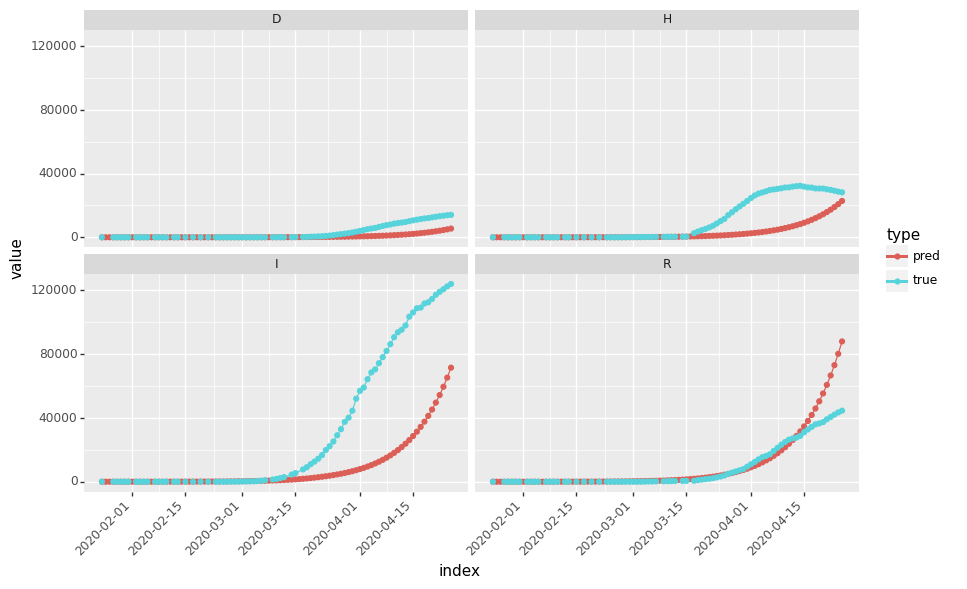

<ggplot: (-9223371856805138404)>

In [545]:
(
    ggplot(data_all_seihdr)
    + aes(x='index', y='value', color='type')
    + geom_line()
    + geom_point()
    + facet_wrap('var')
    + theme(
        figure_size=(10, 6), 
        axis_text_x=element_text(rotation=45, hjust=1)
    )
)

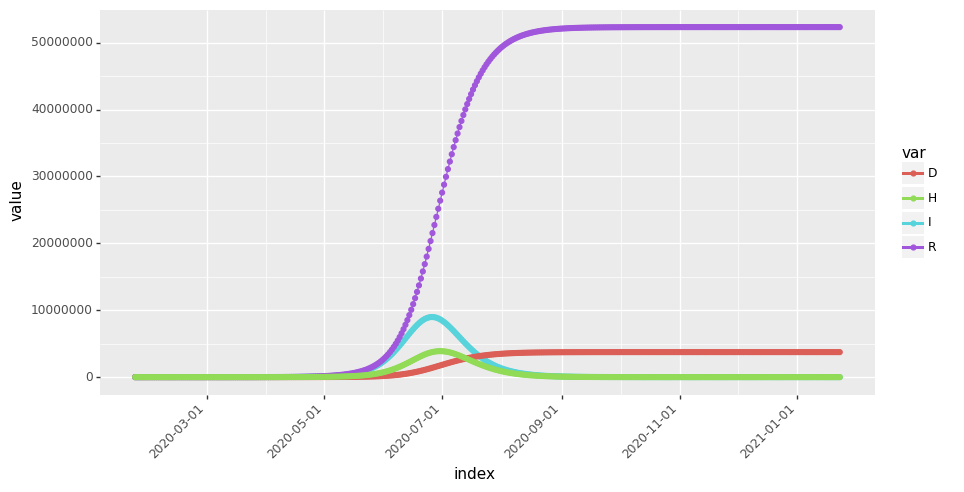

<ggplot: (-9223371856805583972)>

In [546]:
(
    ggplot(
        data_pred_seihdr
        .melt(
            id_vars=['index'], 
            value_vars=['I', 'D', 'R', 'H'], 
            var_name='var', 
            value_name='value'
        )
    )
    + aes(x='index', y='value', color='var')
    + geom_line()
    + geom_point()
    + theme(
        figure_size=(10, 5), 
        axis_text_x=element_text(rotation=45, hjust=1)
    )
)